# Satellite Image Segmentation of Nepal
**Prepared By:** Ajeeb Rimal | M. Tech. AI | Kathmandu University

## Notebook setup and imports

In [1]:
import cv2
%reload_ext autoreload
%autoreload 2

import os
import random
from rasterio.features import shapes
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from osgeo import ogr, gdal
from torchvision.transforms import transforms
import geopandas as gpd

from generator import NepalDataset, NepalDataGenerator
from pan import PAN
from train import train_model
from utils import create_patches, visualize,rasterize_masks,setup_logger
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet50

## Directory definitions
We have defined the directory paths for the dataset, image, and mask files. We have also defined and created the output directory where the patches will be saved.Additionally we have defined the patch size, stride, and boundary for the patches. The boundary is defined as a list of four values: [min_x, min_y, max_x, max_y] which represent the minimum and maximum x and y coordinates of the area of interest, respectively. We have used the `os` library to create the output directory if it does not exist.

In [2]:
mission_list = ['Mission 1', 'Mission 2', 'Mission 3', 'Mission 4', 'Mission 5']
dataset_dir = os.path.join('/', 'Users', 'ajeebrimal', 'Documents', 'Masters Thesis', 'Datasets', 'Rupandehi Data')
annotations_dir = os.path.join(dataset_dir, 'Annotations')
image_dir = os.path.join(dataset_dir, 'TIF Files')
mask_dirs = [os.path.join(annotations_dir, mask_dir) for mask_dir in mission_list]
mask_paths = [os.path.join(mask_dir, f'{mission}.shp') for mask_dir, mission in zip(mask_dirs, mission_list)]
image_paths = [os.path.join(image_dir, f'{mission}.tif') for mission in mission_list]

In [3]:
output_dir = os.path.join('.', 'output')
os.makedirs(output_dir, exist_ok=True)

rasterized_dir = os.path.join(output_dir, 'rasterized_outputs')
os.makedirs(rasterized_dir, exist_ok=True)

mask_paths_rasterized = [os.path.join(rasterized_dir, f'{mission}_rasterized.tif') for mission in mission_list]

In [4]:
patch_size = 512
stride = 256
boundary = [3053710.461731, 751158.377075, 3055429.699707, 753175.112122]

patch_output_dir = os.path.join(output_dir, f"{patch_size}x{patch_size}")
os.makedirs(patch_output_dir, exist_ok=True)

#### Log setup

In [5]:
# Ensure the log directory exists
log_dir = os.path.join('.', 'logs')
os.makedirs(log_dir, exist_ok=True)

logger = setup_logger(log_dir)
logger.info("Logger setup complete.")

2025-02-02 15:32:51,584 - ./logs - INFO - Logger setup complete. [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/83787627.py:6]


## Dataset preparation

### Rasterize the mask
Rasterize the mask to the same projection and pixel resolution as the reference image. We have used the `gdal` library to rasterize the mask. The `gdal` library is a translator library for raster and vector geospatial data formats. It also includes a variety of useful command-line utilities for data translation and processing.

In [ ]:
import os
import concurrent.futures

# Use ThreadPoolExecutor to run rasterization in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(rasterize_masks, image_file_path, mask_shape_file_path,rasterized_dir,logger) for image_file_path, mask_shape_file_path in zip(image_paths, mask_paths)]
    concurrent.futures.wait(futures)

### Create image and mask patches

To prepare the satellite images and masks for segmentation, we first need to convert them into smaller patches. Here's how we can do it:

1. Use the `create_patches()` function from the `utils` module.
2. Pass the following parameters to the function:
    - The file path of the satellite image in `.tif` format.
    - The file path of the mask in `.shp` format.
    - The output directory where the created patches will be saved.
    - The patch size (we use the same value for height and width).
    - The stride.
    - A boundary that defines the area of interest.
3. The function will iterate over the satellite image in patches of the specified size and stride.
4. For each patch, the function will check if it intersects with any mask geometries (which are shapes such as polygons, lines, points, etc. that represent the features belonging to certain classes).
5. If the patch intersects with any mask geometries, the function will create a patch mask by rasterizing the intersecting mask geometries. Otherwise, it will discard the patch.
6. The function will save the patch and its corresponding patch mask to the output directory.

In [91]:
from utils import create_patches_one_hot, create_patches_categorical

min_mask_coverage=0.1 # Percentage of minimum mask coverage in the patch

# Iterate over image and mask paths
for image_path, mask_path in zip(image_paths, mask_paths_rasterized):
    # Pass `outer_pbar` to the inner function
    create_patches_categorical(
        image_path=image_path,
        mask_path=mask_path,
        output_dir=patch_output_dir,
        patch_size=patch_size,
        stride=stride,
        logger=logger,
        min_mask_coverage=min_mask_coverage
    )

Patches for Mission 1:   0%|          | 0/18875 [00:00<?, ?patch/s]

2025-01-22 23:40:45,354 - ./logs - INFO - Completed: 'Mission 1' with 18875 patches processed, 2903 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


Patches for Mission 2:   0%|          | 0/14940 [00:00<?, ?patch/s]

2025-01-22 23:41:01,492 - ./logs - INFO - Completed: 'Mission 2' with 14940 patches processed, 2465 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


Patches for Mission 3:   0%|          | 0/14762 [00:00<?, ?patch/s]

2025-01-22 23:41:27,531 - ./logs - INFO - Completed: 'Mission 3' with 14762 patches processed, 4962 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


Patches for Mission 4:   0%|          | 0/9694 [00:00<?, ?patch/s]

2025-01-22 23:41:38,612 - ./logs - INFO - Completed: 'Mission 4' with 9694 patches processed, 1547 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


Patches for Mission 5:   0%|          | 0/10088 [00:00<?, ?patch/s]

2025-01-22 23:41:51,851 - ./logs - INFO - Completed: 'Mission 5' with 10088 patches processed, 1807 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


### Split the dataset into training and validation sets
This process organizes satellite image data and corresponding masks into `train`, `val`, and `test` directories while maintaining alignment between images and masks. Here's an overview of the steps:
1. **Input Data**:
    - The input directories contain images and their corresponding masks:
        - `images/`: Contains satellite patch images (e.g., `Mission 1_patch_112.jpg`).
        - `masks/`: Contains segmentation/rasterized mask files corresponding to these images (e.g., `Mission 1_patch_112_mask.jpg`).

    - All files are matched and checked to ensure that every image has a corresponding mask.

2. **Mission Extraction**:
    - The filenames follow a predefined naming convention (e.g., `Mission 1_patch_112.jpg` and `Mission 1_patch_112_mask.jpg`).
    - From the filenames, the mission name (`Mission 1`) is extracted and used as a label for stratification to ensure an even distribution of data during splits.

3. **Sorting and Validation**:
    - The image and mask paths are sorted to ensure alignment.
    - If any discrepancies occur (e.g., missing masks for images), the process halts and raises an error.

4. **Stratified Splits**:
    - The dataset is split into training, validation, and test sets:
        - **Training Set**: 60% of the total images.
        - **Validation Set**: 20% of the total images.
        - **Test Set**: 20% of the total images.

    - A stratified sampling approach is used to ensure that the mission distribution is consistent across all subsets.

5. **Directory Structure Creation**:
    - A structured directory system is created for the split datasets:

     ```dataset_split/
     ├── train/
     │   ├── images/
     │   └── masks/
     ├── val/
     │   ├── images/
     │   └── masks/
     └── test/
         ├── images/
         └── masks/
6. **File Movement**:
    - The image and mask files are moved into their respective subset directories (`images` and `masks` folders under `train`, `val`, and `test`).
    - Each file is carefully moved to maintain alignment between the images and their masks.

7. **Output**:
    - The final output is a set of well-organized directories containing training, validation, and test data, ready for use in machine learning workflows.

This process ensures data integrity and proper splitting, allowing fair evaluation of models during training, validation, and testing stages.


In [105]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set directory for the input images and masks
input_images_dir = os.path.join(patch_output_dir, 'images')
input_masks_dir = os.path.join(patch_output_dir, 'masks')

# Directory to store the split dataset
split_output_dir = os.path.join(patch_output_dir, 'dataset_split')
train_output_dir = os.path.join(split_output_dir, 'train')
val_output_dir = os.path.join(split_output_dir, 'val')
test_output_dir = os.path.join(split_output_dir, 'test')

# Gather all image files and their corresponding masks using updated naming convention
all_image_paths = []
all_mask_paths = []
unpaired_images = []
unpaired_masks = []

for fname in os.listdir(input_images_dir):
    if fname.endswith(".jpg"):
        mask_name = fname.replace(".jpg", "_mask.jpg")  # Ensure masks follow the naming convention
        image_path = os.path.join(input_images_dir, fname)
        mask_path = os.path.join(input_masks_dir, mask_name)

        if os.path.exists(mask_path):  # Pair only if the corresponding mask exists
            all_image_paths.append(image_path)
            all_mask_paths.append(mask_path)
        else:
            # Log unpaired image
            unpaired_images.append(image_path)

# Log unpaired masks
for fname in os.listdir(input_masks_dir):
    if fname.endswith("_mask.jpg"):
        image_name = fname.replace("_mask.jpg", ".jpg")
        image_path = os.path.join(input_images_dir, image_name)
        if not os.path.exists(image_path):
            unpaired_masks.append(os.path.join(input_masks_dir, fname))

# Print logs for unpaired files
if unpaired_images:
    logger.warning(f"Unpaired images found: {len(unpaired_images)}")
    for img in unpaired_images:
        logger.warning(f"Unpaired image: {img}")

if unpaired_masks:
    logger.warning(f"Unpaired masks found: {len(unpaired_masks)}")
    for mask in unpaired_masks:
        logger.warning(f"Unpaired mask: {mask}")

# Ensure input directories contain valid paired files
if not all_image_paths or not all_mask_paths:
    raise ValueError("No valid image-mask pairs found. Check the directories for properly paired `.jpg` files.")

# Ensure that the total number of images matches the total number of masks
if len(all_image_paths) != len(all_mask_paths):
    raise ValueError(
        "The number of image files does not match the number of mask files. Ensure all images have corresponding masks."
    )

# Perform train-test-validation split
train_images, temp_images, train_masks, temp_masks = train_test_split(
    all_image_paths, all_mask_paths,
    test_size=0.4, random_state=42
)

# Further split validation and test sets
val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks,
    test_size=0.5, random_state=42
)

# Confirm dataset sizes
logger.debug(f"Training set size: {len(train_images)}")
logger.debug(f"Validation set size: {len(val_images)}")
logger.debug(f"Test set size: {len(test_images)}")

# Create necessary output directories for train, val, and test splits
for dir_path in [train_output_dir, val_output_dir, test_output_dir]:
    os.makedirs(os.path.join(dir_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'masks'), exist_ok=True)

# Helper function to move files
def move_files_to_split(file_paths, target_dir, subfolder_name):
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        destination_path = os.path.join(target_dir, subfolder_name, filename)
        if os.path.exists(destination_path):  # Handle potential overwrite issues
            logger.warning(f"File already exists and won't be overwritten: {destination_path}")
        else:
            shutil.move(file_path, destination_path)

# Move split files into their respective directories
# Training set
move_files_to_split(train_images, train_output_dir, 'images')
move_files_to_split(train_masks, train_output_dir, 'masks')

# Validation set
move_files_to_split(val_images, val_output_dir, 'images')
move_files_to_split(val_masks, val_output_dir, 'masks')

# Test set
move_files_to_split(test_images, test_output_dir, 'images')
move_files_to_split(test_masks, test_output_dir, 'masks')

logger.info(f"Files have been successfully split and moved to {split_output_dir}.")

Training set size: 8210
Validation set size: 2737
Test set size: 2737
Files have been successfully split and moved to ./output/512x512/dataset_split.


### Merge the split dataset back into a unified dataset

In [104]:
import os
import shutil

# Set the directory for the split dataset
split_output_dir = os.path.join(patch_output_dir, 'dataset_split')
train_output_dir = os.path.join(split_output_dir, 'train')
val_output_dir = os.path.join(split_output_dir, 'val')
test_output_dir = os.path.join(split_output_dir, 'test')

# Set the destination directory for the merged dataset
merged_output_dir = os.path.join(patch_output_dir, 'merged_dataset')
output_images_dir = os.path.join(merged_output_dir, 'images')
output_masks_dir = os.path.join(merged_output_dir, 'masks')

# Create the merged directories if they don't exist
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)


# Helper function to merge files
def merge_split_files(split_dirs, source_subfolder, output_dir):
    for split_dir in split_dirs:
        source_dir = os.path.join(split_dir, source_subfolder)

        if os.path.exists(source_dir):
            for fname in os.listdir(source_dir):
                source_path = os.path.join(source_dir, fname)
                destination_path = os.path.join(output_dir, fname)

                if os.path.exists(destination_path):  # Handle duplicates
                    logger.warning(f"File already exists in the merged directory and won't be duplicated: {destination_path}")
                else:
                    shutil.move(source_path, destination_path)


# List of split directories
split_dirs = [train_output_dir, val_output_dir, test_output_dir]

# Merge images and masks back into unified directories
merge_split_files(split_dirs, 'images', output_images_dir)
merge_split_files(split_dirs, 'masks', output_masks_dir)

logger.info(f"Files have been successfully merged into {merged_output_dir}.")


Files have been successfully merged into ./output/512x512/merged_dataset.


### Visualize a random image patch and its mask
We can visualize a random patch and its mask using the `rasterio` and `matplotlib` libraries. The `rasterio` library is a Python package that provides a fast and direct way to work with raster data. We can use the `rasterio.open()` function to open the image and mask files. We can then use the `read()` function to read the image and mask data. We can then use the `imshow()` function from the `matplotlib.pyplot` module to display the image and the mask.

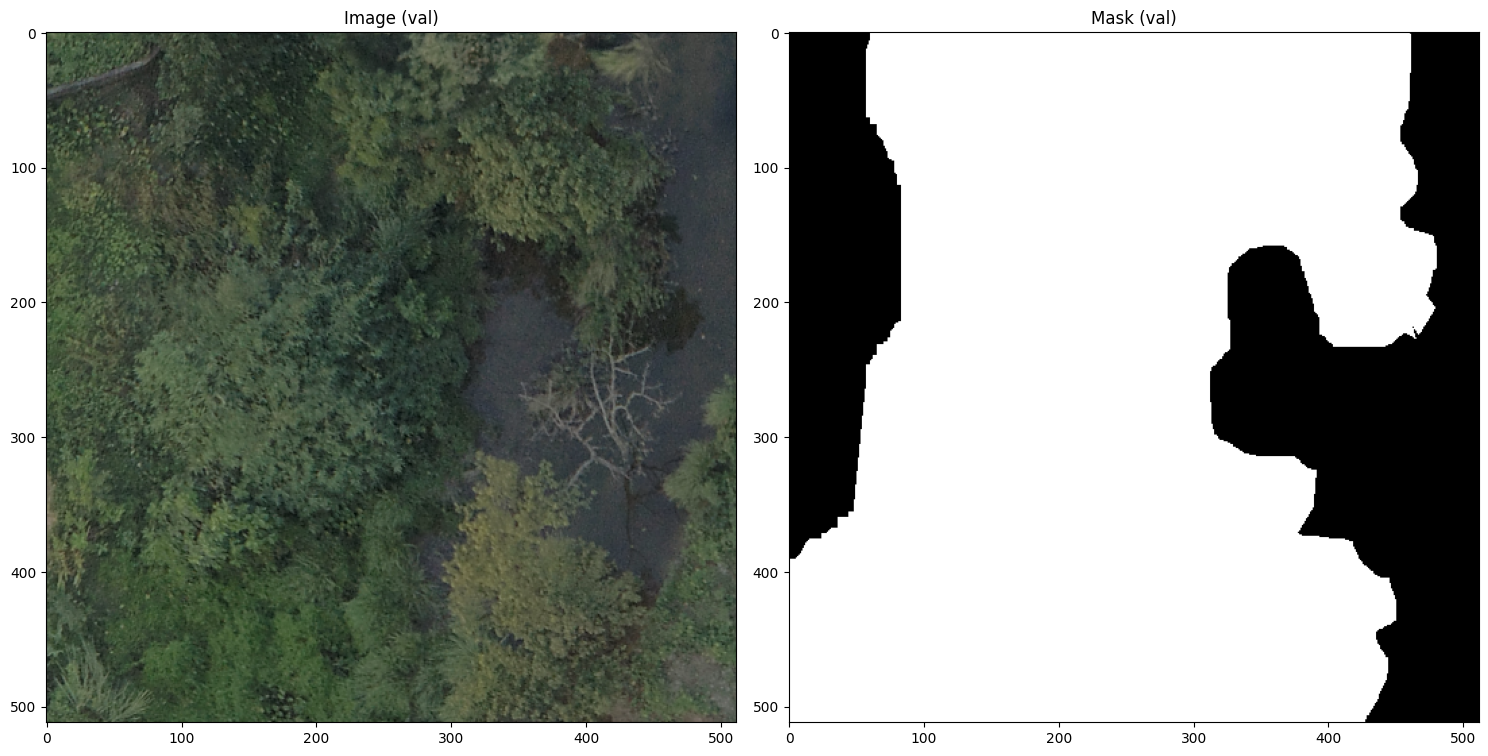

2025-01-23 00:11:45,261 - ./logs - DEBUG - Selected subset: val [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_77558/2985303614.py:63]
2025-01-23 00:11:45,262 - ./logs - DEBUG - Image shape: (4, 512, 512) [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_77558/2985303614.py:64]
2025-01-23 00:11:45,262 - ./logs - DEBUG - Mask shape: (1, 512, 512) [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_77558/2985303614.py:65]


In [126]:
import os
import random
import rasterio
import matplotlib.pyplot as plt

# Set the base path for the dataset_split directory
dataset_split_dir = os.path.join(patch_output_dir, "dataset_split")

# Choose a random subset (train, val, or test)
subsets = ['train', 'val', 'test']
random_subset = random.choice(subsets)

# Get paths of images and masks within the chosen subset
subset_images_dir = os.path.join(dataset_split_dir, random_subset, "images")
subset_masks_dir = os.path.join(dataset_split_dir, random_subset, "masks")

# Get list of all image files in the chosen subset
image_files = [f for f in os.listdir(subset_images_dir) if f.endswith('.jpg')]

# Ensure the subset has valid image files
if not image_files:
    raise ValueError(f"No image files found in the {random_subset} subset.")

# Select a random image file
random_image_file = random.choice(image_files)

# Construct the full paths to the randomly selected image and corresponding mask files
temp_image_path = os.path.join(subset_images_dir, random_image_file)
temp_mask_path = os.path.join(subset_masks_dir, random_image_file.replace(".jpg", "_mask.jpg"))

# Open the image and mask files using Rasterio
with rasterio.open(temp_image_path) as src:
    image = src.read().astype(float)
    image_transform = src.transform

with rasterio.open(temp_mask_path) as src:
    mask = src.read()
    mask_transform = src.transform

# The image data read by Rasterio is in (bands, rows, cols) order
# Convert the image data to (rows, cols, bands) order for visualization
transposed_image = image.transpose((1, 2, 0))

# Scale the image data to be between 0 and 1 for better visualization
transposed_image -= transposed_image.min()
transposed_image /= transposed_image.max()

# Create side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# Display the image
ax[0].imshow(transposed_image)
ax[0].set_title(f"Image ({random_subset})")

# Display the mask
ax[1].imshow(mask[0], cmap='gray')
ax[1].set_title(f"Mask ({random_subset})")

plt.tight_layout()
plt.show()

# Print shapes for additional information
logger.debug(f'Selected subset: {random_subset}')
logger.debug(f'Image shape: {image.shape}')
logger.debug(f'Mask shape: {mask.shape}')

### Dataset and data generator

We define the dataset and data generator that will be used for training the model. To define the dataset and data generator, we can use the `NepalDataset` and `NepalDataGenerator` classes from the `dataset` module. This code takes a dataset and generates batches of data for training a deep learning model.

In [6]:
dataset_split_dir = os.path.join(patch_output_dir, "dataset_split")
data_path = dataset_split_dir  # Base path to the split dataset directories
in_channels = 4
num_classes = 3
batch_size = 4
shuffle = True

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create datasets for train, val, and test splits
train_dataset = NepalDataset(data_path, split="train", transform=transform)
val_dataset = NepalDataset(data_path, split="val", transform=transform)
test_dataset = NepalDataset(data_path, split="test", transform=transform)

# Print dataset sizes
logger.debug(f"Train dataset size: {len(train_dataset)}")
logger.debug(f"Validation dataset size: {len(val_dataset)}")
logger.debug(f"Test dataset size: {len(test_dataset)}")

# Create data generators for each dataset
train_data_generator = NepalDataGenerator(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_data_generator = NepalDataGenerator(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_data_generator = NepalDataGenerator(test_dataset, batch_size=batch_size, shuffle=False)  # Do not shuffle test data

# Print data generator sizes
logger.debug(f"Train data generator size: {len(train_data_generator)}")
logger.debug(f"Validation data generator size: {len(val_data_generator)}")
logger.debug(f"Test data generator size: {len(test_data_generator)}")


2025-02-02 15:36:43,872 - ./logs - DEBUG - Train dataset size: 8210 [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3935941498.py:18]
2025-02-02 15:36:43,872 - ./logs - DEBUG - Validation dataset size: 2737 [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3935941498.py:19]
2025-02-02 15:36:43,872 - ./logs - DEBUG - Test dataset size: 2737 [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3935941498.py:20]
2025-02-02 15:36:43,872 - ./logs - DEBUG - Train data generator size: 2053 [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3935941498.py:28]
2025-02-02 15:36:43,872 - ./logs - DEBUG - Validation data generator size: 685 [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3935941498.py:29]
2025-02-02 15:36:43,872 - ./logs - DEBUG - Test data generator size: 685 [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3935941498.py:30]


### Visualize data generator output image and mask patches

This code visualizes the patches and patch masks that were created using the data generator. To visualize the patches and patch masks, we can use the `visualize()` function from `utils` module.

Image shape: (512, 512, 3)
Mask shape: (512, 512)


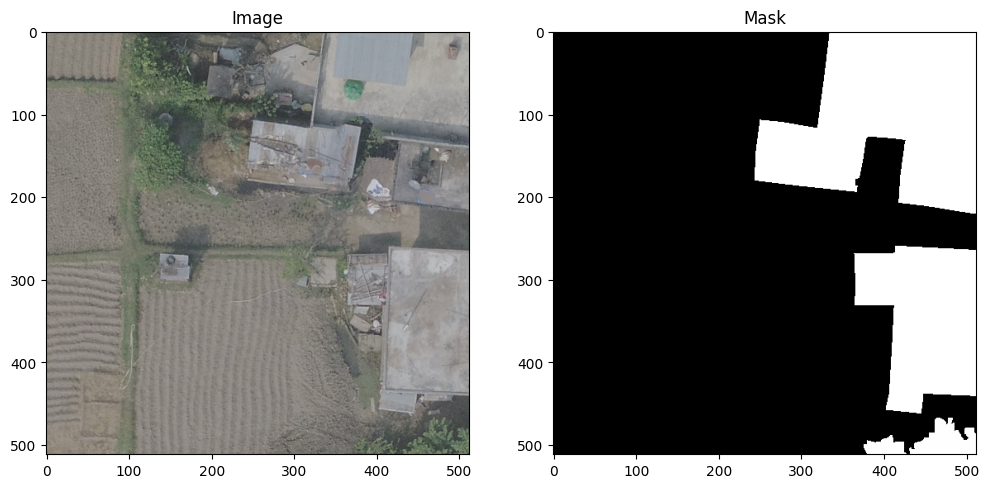

Image shape: (512, 512, 3)
Mask shape: (512, 512)


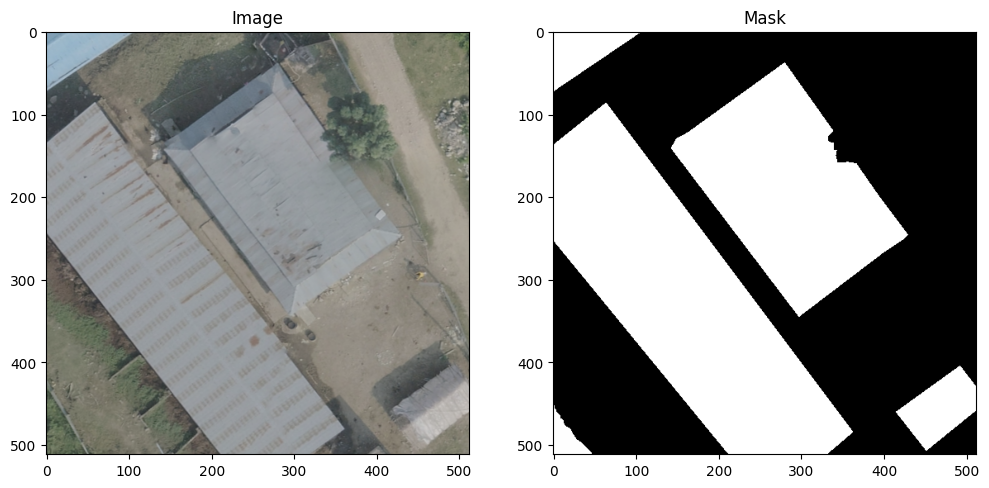

Image shape: (512, 512, 3)
Mask shape: (512, 512)


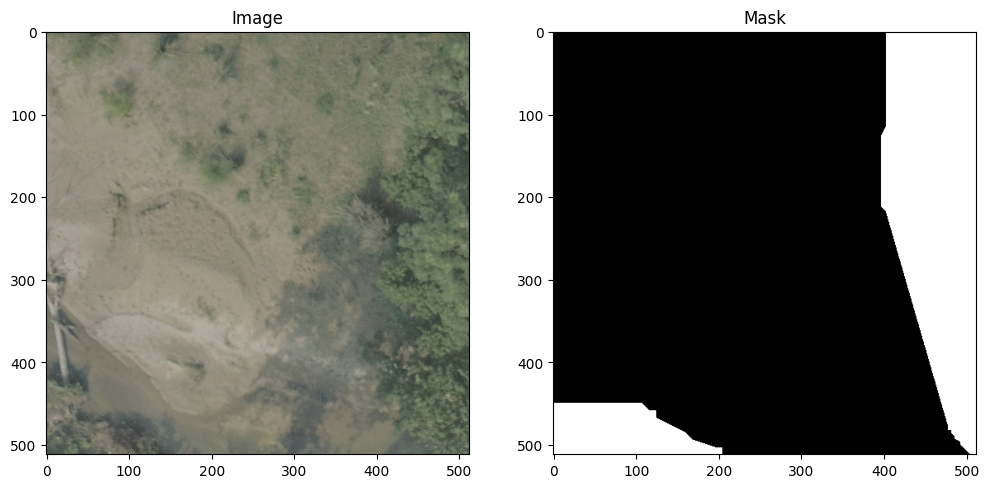

In [7]:
no_of_images_to_show = 3  # Number of images to show from the batch

# Select the data_generator to visualize (train/validation/test)
selected_data_generator = train_data_generator  # Change to val_data_generator or test_data_generator as needed

# Get the batch of images and masks
images, masks = selected_data_generator.__next__()

if no_of_images_to_show > batch_size:
    no_of_images_to_show = batch_size

# Visualize the specified number of images and masks from the batch
for i in range(0, no_of_images_to_show):
    image = images[i].permute(1, 2, 0).numpy()  # Access individual image and convert to numpy array
    mask = masks[i].squeeze().numpy()  # Access individual mask and convert to numpy array
    visualize(image, mask)


## Training

### Model Definition


In [8]:
from torchvision.models.segmentation import deeplabv3_resnet50,DeepLabV3_ResNet50_Weights


# Load the DeepLabV3 model
model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)

# Modify the classifier for the number of classes
num_classes = 2
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

# Move the model to GPU if available
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
model = model.to(device)

In [9]:
# Define CrossEntropyLoss for segmentation
criterion = nn.CrossEntropyLoss()

# Define optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
def train_model(model, train_data_generator, val_data_generator, criterion, optimizer, num_epochs):
    # Train and validate the model
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        model.train()
        train_loss = 0.0

        for images, masks in train_data_generator:
            images = images.to(device)
            masks = masks.long().to(device)  # Ensure masks are of integer type for classification

            # Forward pass
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_data_generator)
        print(f"Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, masks in val_data_generator:
                images = images.to(device)
                masks = masks.long().to(device)

                # Forward pass
                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_data_generator)
        print(f"Validation Loss: {avg_val_loss:.4f}")

    print("Training complete!")
    return model

In [11]:
from utils import calculate_metrics
import mlflow
import mlflow.pytorch
import os

def save_model(model, output_dir, model_name, model_type, logger):
    """
    Save the model to the output directory with specific naming.

    Parameters:
        model (torch.nn.Module): Trained model to save
        output_dir (str): Directory where the model should be saved
        model_name (str): Name of the model
        model_type (str): Type of the model ('best' or 'last')
        logger (logging.Logger): Logger instance to log messages
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the models directory exists
    model_path = os.path.join(output_dir, f"{model_name}_{model_type}.pth")
    torch.save(model.state_dict(), model_path)
    logger.info(f"Model ({model_type}) saved as {model_path}.")
    return model_path

def train_model_with_mlflow(
        model, train_data_generator, val_data_generator, criterion, optimizer, num_epochs, num_classes, model_name, output_dir, logger
):
    mlflow.start_run()  # Start the MLflow run

    # Log model parameters
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", optimizer.param_groups[0]["lr"])
    mlflow.log_param("batch_size", train_data_generator.batch_size)

    best_val_loss = float('inf')  # Track the best validation loss
    models_dir = os.path.join(output_dir, "models")  # Directory to save models
    last_epoch_model_path = None  # Path for the last epoch model

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        model.train()
        train_loss = 0.0
        train_metrics = {"IoU": [], "F1-Score": [], "Pixel Accuracy": 0.0}

        for images, masks in train_data_generator:
            images = images.to(device)
            masks = masks.long().to(device)

            # Forward pass
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate metrics
            batch_metrics = calculate_metrics(outputs, masks, num_classes)
            for key in train_metrics.keys():
                if isinstance(train_metrics[key], list):
                    train_metrics[key].append(batch_metrics[key].mean())
                else:
                    train_metrics[key] += batch_metrics[key]

        avg_train_loss = train_loss / len(train_data_generator)
        avg_train_metrics = {k: (sum(v) / len(v) if isinstance(v, list) else v / len(train_data_generator))
                             for k, v in train_metrics.items()}
        mlflow.log_metrics(avg_train_metrics, step=epoch)  # Log training metrics
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Train Metrics: {avg_train_metrics}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_metrics = {"IoU": [], "F1-Score": [], "Pixel Accuracy": 0.0}

        with torch.no_grad():
            for images, masks in val_data_generator:
                images = images.to(device)
                masks = masks.long().to(device)

                # Forward pass
                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Calculate metrics
                batch_metrics = calculate_metrics(outputs, masks, num_classes)
                for key in val_metrics.keys():
                    if isinstance(val_metrics[key], list):
                        val_metrics[key].append(batch_metrics[key].mean())
                    else:
                        val_metrics[key] += batch_metrics[key]

        avg_val_loss = val_loss / len(val_data_generator)
        avg_val_metrics = {k: (sum(v) / len(v) if isinstance(v, list) else v / len(val_data_generator))
                           for k, v in val_metrics.items()}
        mlflow.log_metrics(avg_val_metrics, step=epoch)  # Log validation metrics

        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Val Metrics: {avg_val_metrics}")

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
        for key in avg_train_metrics.keys():
            mlflow.log_metric(f"train_{key}", avg_train_metrics[key], step=epoch)
            mlflow.log_metric(f"val_{key}", avg_val_metrics[key], step=epoch)

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = save_model(model, models_dir, model_name, "best", logger)
            mlflow.log_artifact(best_model_path)
            print(f"Best model updated and saved as {best_model_path} with validation loss: {best_val_loss:.4f}")

        # Save the model from the current (last) epoch
        last_epoch_model_path = save_model(model, models_dir, model_name, "last", logger)

    # Save the final model to MLflow
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_artifact(last_epoch_model_path)
    print(f"Final model from the last epoch saved as {last_epoch_model_path}")

    mlflow.end_run()

In [18]:
model_name = "deeplabv3 - resnet50"
mlflow.set_experiment(f"Satellite Segmentation of Nepal - {model_name}")
num_epochs = 5
num_classes=2
trained_model = train_model_with_mlflow(
    model=model,
    train_data_generator=train_data_generator,
    val_data_generator=val_data_generator,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    num_classes=num_classes,
    model_name=model_name,
    output_dir=output_dir,
    logger=logger
)

Epoch 1/5
--------------------------------------------------
Train Loss: 0.0191
Train Metrics: {'IoU': 0.7773940929888054, 'F1-Score': 0.5418653243992076, 'Pixel Accuracy': 0.9869016730315036}
Val Loss: 0.0138
Val Metrics: {'IoU': 0.787046082959558, 'F1-Score': 0.5450663594868932, 'Pixel Accuracy': 0.9901548172435621}


INFO:./logs:Model (best) saved as ./output/models/deeplabv3 - resnet50_best.pth.


2025-02-02 17:53:27,210 - ./logs - INFO - Model (best) saved as ./output/models/deeplabv3 - resnet50_best.pth. [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3834012773.py:20]
Best model updated and saved as ./output/models/deeplabv3 - resnet50_best.pth with validation loss: 0.0138


INFO:./logs:Model (last) saved as ./output/models/deeplabv3 - resnet50_last.pth.


2025-02-02 17:53:27,562 - ./logs - INFO - Model (last) saved as ./output/models/deeplabv3 - resnet50_last.pth. [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3834012773.py:20]
Epoch 2/5
--------------------------------------------------
Train Loss: 0.0159
Train Metrics: {'IoU': 0.7861539990334062, 'F1-Score': 0.5444728403601249, 'Pixel Accuracy': 0.9891917431464848}
Val Loss: 0.0132
Val Metrics: {'IoU': 0.7924231776355827, 'F1-Score': 0.5475264359129607, 'Pixel Accuracy': 0.9901302972849269}


INFO:./logs:Model (best) saved as ./output/models/deeplabv3 - resnet50_best.pth.


2025-02-02 18:51:04,674 - ./logs - INFO - Model (best) saved as ./output/models/deeplabv3 - resnet50_best.pth. [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3834012773.py:20]
Best model updated and saved as ./output/models/deeplabv3 - resnet50_best.pth with validation loss: 0.0132


INFO:./logs:Model (last) saved as ./output/models/deeplabv3 - resnet50_last.pth.


2025-02-02 18:51:04,943 - ./logs - INFO - Model (last) saved as ./output/models/deeplabv3 - resnet50_last.pth. [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_21437/3834012773.py:20]
Epoch 3/5
--------------------------------------------------


KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, test_data_generator):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in test_data_generator:
            images = images.to(device)
            masks = masks.long().to(device)

            # Forward pass
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_data_generator)
    print(f"Test Loss: {avg_test_loss:.4f}")

In [ ]:
def log_evaluation_metrics(model, data_generator):
    """
    Evaluate the model on a given data generator and log metrics

    Parameters:
        model (torch.nn.Module): The trained model
        data_generator: The data generator (e.g., test_data_generator)
    """
    model.eval()  # Make sure the model is in evaluation mode
    test_metrics = {"IoU": 0.0, "F1-Score": 0.0, "Pixel Accuracy": 0.0}
    avg_test_loss = 0.0

    with torch.no_grad():
        for images, masks in data_generator:
            images = images.to(device)
            masks = masks.long().to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            avg_test_loss += loss.item()
            batch_metrics = calculate_metrics(outputs, masks, num_classes)  # Define this appropriately
            for key in test_metrics.keys():
                test_metrics[key] += batch_metrics[key]

    avg_metrics = {k: (v / len(data_generator)) for k, v in test_metrics.items()}
    avg_loss = avg_test_loss / len(data_generator)
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Metrics: {avg_metrics}")
    mlflow.log_metrics(avg_metrics)  # Log test metrics to MLflow
    mlflow.log_metric("test_loss", avg_loss)


In [ ]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

def load_trained_model(model_path: str):
    from torchvision.models.segmentation import deeplabv3_resnet50,DeepLabV3_ResNet50_Weights

    # Load the DeepLabV3 model
    trained_model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)

    # Modify the classifier for the number of classes
    num_classes = 2
    trained_model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

    # Move the trained model to GPU if available
    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
    trained_model = trained_model.to(device)
    trained_model.load_state_dict(torch.load(model_path, map_location=device))  # Load weights
    trained_model.eval()  # Set trained model to evaluation mode
    return trained_model

In [ ]:
trained_model_path=r'output/models/deeplabv3 - resnet50 - 100epochs_best.pth'

loaded_trained_model = load_trained_model(trained_model_path)
log_evaluation_metrics(loaded_trained_model, test_data_generator)